In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

sns.set_style('whitegrid')

In [129]:
df = pd.read_csv('../data/2018_2021/to_model.csv', index_col=0)

In [130]:
df['log_exposure_22'] = np.log(df['exposure_22'])

In [131]:
df.sample(3)

,State,CountyName,City,pct_fair_plan,exposure_22,earned_premium_y,growth_premium,fire_smoke_claims,fire_smoke_losses,growth_fire_smoke_claims,...,New_and_Renewed_to_Nonrenewed_Ratio,New_and_Renewed_to_Total_Units_Ratio,Premium_to_Exposure_Ratio,Nonrenewal_Rate,Renewal_Resilience,Housing_Affordability_Ratio,Relative_Housing_Cost_Index,Climate_Disasters_Avf_10yr,total_units_y,log_exposure_22
ZIP Code,,,,,,,,,,,,,,,,,,,,,
95969,CA,Butte County,Paradise,0.095391,340924657,32817862,-0.692924,18631,4.277700e+09,-0.999570,...,3.257598,6.746036,899.760432,0.255534,0.744466,5.901649,27684.711143,0.0,4036,19.647172
94040,CA,Santa Clara County,Mountain View,0.000582,1554996,27829847,0.258846,18,3.219050e+05,0.000000,...,12.069290,4.222028,558.406176,0.082973,0.917027,14.248624,168748.005073,0.0,5157,14.256984
92029,CA,San Diego County,Escondido,0.051868,412223853,35554538,0.449404,49,5.955910e+06,-0.583333,...,7.376951,4.011886,1164.195743,0.137860,0.862140,7.251849,60264.326393,0.0,6478,19.837077


In [132]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, root_mean_squared_error as rmse
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [133]:
df_train, df_test = train_test_split(
    df,
    test_size=.2,
    random_state=13348,
    shuffle=True
)

In [134]:
df_train.shape, df_test.shape

((926, 49), (232, 49))

In [135]:
eval = pd.DataFrame(columns=['rmse', 'mse', 'mae', 'global_diff'])
eval

,rmse,mse,mae,global_diff


In [136]:
def plot_metrics(eval):

    assert eval.shape[0] >= 1, ('Evaluation dataframe is empty.')
    

    cols = eval.shape[0] * 2

    eval.plot.bar(y=['rmse', 'mae'], rot=0, figsize=(cols,3), width=.8)

    plt.legend()
    plt.show()

def measure_diff(y_true, preds):
    return round( abs((sum(y_true)-sum(preds)) / (1000 * 1000)), 2)

def calculate_metrics(y_true, preds):
    return [rmse(y_true, preds), 
            mse(y_true, preds), 
            mae(y_true, preds), 
            measure_diff(y_true, preds)]

In [137]:
target = 'pct_fair_plan'  # 'exposure_22' or 'pct_fair_plan' 

features = df.columns[6:]

strong_features = ["Renewal_Resilience","New_and_Renewed_to_Nonrenewed_Ratio",
                   "median_gross_rent","Avg_Percentage_2018_2021",
                   "change_new_policies","Premium_to_Exposure_Ratio",
                   "growth_premium","pct_nonrenewed_owner"]

## Base Model

Here we train two base models using mean and median to compare to other algorithms.

In [138]:
mu_y = df_train[target].mean()
preds = [mu_y] * df_test.shape[0]
eval.loc['base_mean'] = calculate_metrics(df_test[target], preds)

In [139]:
median_y = df_train[target].median()
preds = [median_y] * df_test.shape[0]
eval.loc['base_median'] = calculate_metrics(df_test[target], preds)


In [140]:
eval

,rmse,mse,mae,global_diff
base_mean,0.102254,0.010456,0.058045,0.0
base_median,0.105356,0.011100,0.036041,0.0


## Linear Regressions

In [141]:
from sklearn.linear_model import LinearRegression

In [142]:
# with all regressors

lr_all = LinearRegression()
lr_all.fit(df_train[features], df_train[target])
preds = lr_all.predict(df_test[features])

eval.loc['lr_all_regs'] = calculate_metrics(df_test[target], preds)

In [143]:
# selected regressors

lr_sel = LinearRegression()
lr_sel.fit(df_train[strong_features], df_train[target])
preds = lr_sel.predict(df_test[strong_features])

eval.loc['lr_sel_regs'] = calculate_metrics(df_test[target], preds)

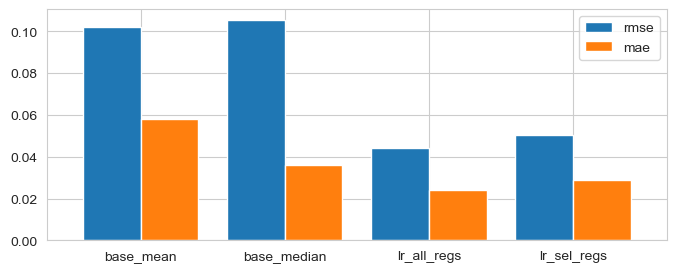

In [144]:
plot_metrics(eval)

## kNN regressor

In [145]:
from sklearn.neighbors import KNeighborsRegressor

In [146]:
# finding best k (that minimizes RMSE)

k_range = range(3, 50)
rmses = []

for k in k_range:
    knn_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=k))
    ])
    
    knn_pipe.fit(df_train[features], df_train[target])
    preds = knn_pipe.predict(df_test[features])

    rmses.append((k, rmse(df_test[target], preds)))

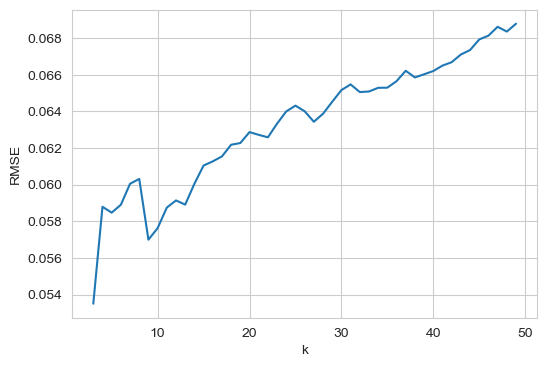

In [147]:
plt.figure(figsize=(6,4))

plt.plot(np.array(rmses)[:, 0], np.array(rmses)[:, 1])

plt.ylabel('RMSE')
plt.xlabel('k')

plt.show()

In [148]:
# training models with k = 9 to avoid overfitting
k = 9

# all features
knn_all = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=k))
])

knn_all.fit(df_train[features], df_train[target])
preds = knn_all.predict(df_test[features])
eval.loc['knn_all'] = calculate_metrics(df_test[target], preds)

In [149]:
# selected features
knn_sel = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=k))
])

knn_sel.fit(df_train[strong_features], df_train[target])
preds = knn_sel.predict(df_test[strong_features])
eval.loc['knn_sel'] = calculate_metrics(df_test[target], preds)

## Gradient Boosting

In [150]:
from sklearn.ensemble import GradientBoostingRegressor

In [151]:
gb_all = GradientBoostingRegressor(
    learning_rate=.1,
    n_estimators=1000,
    max_depth=1
)

gb_all.fit(df_train[features], df_train[target])
preds = gb_all.predict(df_test[features])
eval.loc['gb_all'] = calculate_metrics(df_test[target], preds)

In [152]:
gb_sel = GradientBoostingRegressor(
    learning_rate=.1,
    n_estimators=1000,
    max_depth=1
)

gb_sel.fit(df_train[strong_features], df_train[target])
preds = gb_sel.predict(df_test[strong_features])
eval.loc['gb_sel'] = calculate_metrics(df_test[target], preds)

## XGBoost

In [153]:
from xgboost import XGBRegressor

In [154]:
xgb_all = XGBRegressor(
    learning_rate=.1,
    n_estimators=1000,
    max_depth=1
)

xgb_all.fit(df_train[features], df_train[target])
preds = xgb_all.predict(df_test[features])
eval.loc['xgb_all'] = calculate_metrics(df_test[target], preds)

In [155]:
xgb_sel = XGBRegressor(
    learning_rate=.1,
    n_estimators=1000,
    max_depth=1
)

xgb_sel.fit(df_train[strong_features], df_train[target])
preds = xgb_sel.predict(df_test[strong_features])
eval.loc['xgb_sel'] = calculate_metrics(df_test[target], preds)

## Cross-validation

In [156]:
from sklearn.model_selection import KFold

In [157]:
models = [('Baseline (mean)', mu_y),
          ('Linear Regression', lr_all), 
          ('kNN', knn_all), 
          ('Gradient Boosting', gb_all), 
          ('XGBoost', xgb_all)]


n_splits = 5
kfold = KFold(n_splits)

results = np.zeros(shape=(len(models), n_splits))
diffs = np.zeros(shape=(len(models), n_splits))
totals = np.zeros(shape=(n_splits))


for i, (train_index, test_index) in enumerate(kfold.split(df_train)):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]

    totals[i] = df_ho[target].sum()

    for j, model in enumerate(models):
        if model[0] == 'Baseline (mean)':
            mu_y = df_tt[target].mean()
            preds = [mu_y] * len(test_index)
        else:
            model[1].fit(df_tt[strong_features], df_tt[target])
            preds = model[1].predict(df_ho[strong_features])

        results[j,i] = rmse(df_ho[target], preds)
        diffs[j,i] = measure_diff(df_ho[target], preds)
        


In [158]:
#results
labels = [m[0] for m in models]
rmses = np.mean(results, axis=1)
diffs2 = np.mean(diffs, axis=1)

pd.DataFrame({
    'models': labels,
    'rmse': rmses,
    'diff': diffs2,
})

,models,rmse,diff
0,Baseline (mean),0.103429,0.0
1,Linear Regression,0.051349,0.0
2,kNN,0.045852,0.0
3,Gradient Boosting,0.046504,0.0
4,XGBoost,0.048250,0.0


In [159]:
np.mean(totals) / (1000*1000)  # average total exposure in millions
np.exp(np.mean(totals) / (1000*1000))

np.float64(1.0000093017344143)

In [40]:
# total exposure of test set
total_exposure = sum(df_test[target]) / (1000*1000)

In [41]:
eval.loc[:, 'global_diff'].min() / total_exposure

np.float64(0.008145090483682369)

In [45]:
eval

,rmse,mse,mae,global_diff
base_mean,3.814628e+08,1.455139e+17,1.691949e+08,6666.430000
base_median,3.914104e+08,1.532021e+17,1.129267e+08,21406.840000
lr_all_regs,3.307531e+08,1.093976e+17,1.353531e+08,1900.940000
lr_sel_regs,3.305889e+08,1.092890e+17,1.380232e+08,253.000000
knn_all,3.159408e+08,9.981858e+16,1.101573e+08,3099.890000
knn_sel,3.155745e+08,9.958728e+16,1.047873e+08,4093.750000
gb_all,2.865112e+08,8.208868e+16,1.105473e+08,1622.460000
gb_sel,3.175257e+08,1.008226e+17,1.215332e+08,228.140000
xgb_all,2.822443e+08,7.966183e+16,1.119294e+08,3540.840088
xgb_sel,3.100571e+08,9.613538e+16,1.286266e+08,305.250000


In [42]:
eval_exp = eval

In [43]:
# converting eval_exp units to millions of $

eval_exp_mi = (eval_exp / (1000 * 1000)).round(2)

In [44]:
cols = ['rmse', 'mae']

merged = pd.concat((eval_exp_mi[cols], eval_fair[cols]), axis=1)

#merged.columns = ['RMSE ()', 'b', 'c', 'd']
merged.columns = pd.MultiIndex.from_tuples([('Exposure', 'RMSE'), ('Exposure', 'MAE'), ('Pct FAIR Plan', 'RMSE'), ('Pct FAIR Plan', 'MAE')])


import seaborn as sns
cm = sns.color_palette("rocket", as_cmap=True)

merged.style.background_gradient(cmap=cm)



NameError: name 'eval_fair' is not defined

MultiIndex([(     'Exposure', 'RMSE'),
            (     'Exposure',  'MAE'),
            ('Pct FAIR Plan', 'RMSE'),
            ('Pct FAIR Plan',  'MAE')],
           )

In [ ]:
tab = tabulate((eval[['rmse', 'mae']]).round(6), 
               tablefmt="pipe",
               headers=["Model", "RMSE", "MAE"])
print(tab)

| Model       |     RMSE |      MAE |
|:------------|---------:|---------:|
| base_mean   | 0.095314 | 0.057739 |
| base_median | 0.101129 | 0.04041  |
| lr_all_regs | 0.06242  | 0.0339   |
| lr_sel_regs | 0.054167 | 0.032555 |
| knn_20_all  | 0.096716 | 0.055577 |
| knn_20_sel  | 0.096716 | 0.055577 |
| gb_all      | 0.039186 | 0.023176 |
| gb_sel      | 0.041296 | 0.024298 |
| xgb_all     | 0.040688 | 0.023824 |
| xgb_sel     | 0.043219 | 0.025379 |


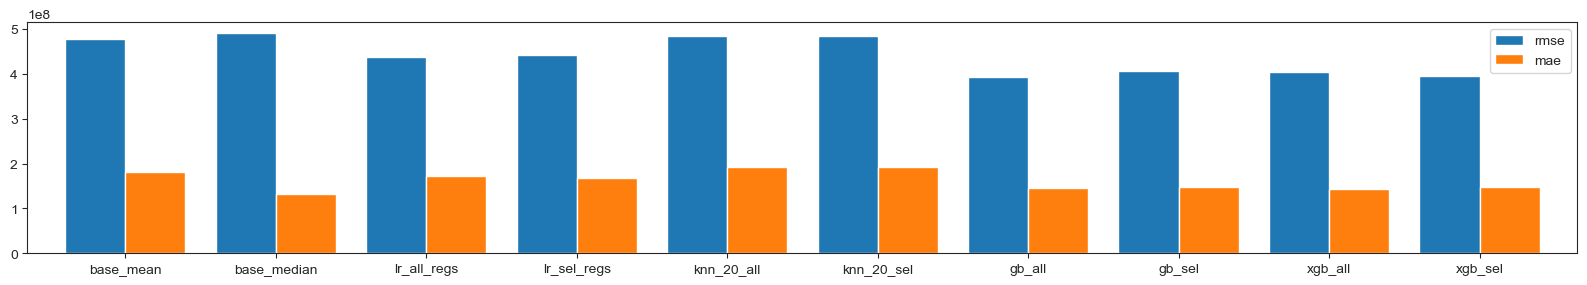

In [30]:
plot_metrics(eval)

In [31]:
df['exposure_22'].sort_values()

1099         95978
1061        148154
754         154072
980         164268
768         171748
           ...    
80      3127641732
1225    3413841672
60      3745871198
1402    4391342786
430     5116111492
Name: exposure_22, Length: 1231, dtype: int64

For Exposure_22 as target

| Model       |   RMSE ($ MI) |   MAE ($ MI) |
|:------------|---------------:|-------------:|
| base_mean   |         477.15 |       181.85 |
| base_median |         490.32 |       131.42 |
| lr_all_regs |         436.67 |       171.83 |
| lr_sel_regs |         441.6  |       168.29 |
| knn_20_all  |         484.88 |       192.39 |
| knn_20_sel  |         484.88 |       192.39 |
| gb_all      |         392.69 |       144.74 |
| gb_sel      |         405.78 |       148.5  |
| xgb_all     |         404.53 |       144.22 |
| xgb_sel     |         395.19 |       148.49 |



Percentual 

| Model       |     RMSE |      MAE |
|:------------|---------:|---------:|
| base_mean   | 0.095314 | 0.057739 |
| base_median | 0.101129 | 0.04041  |
| lr_all_regs | 0.06242  | 0.0339   |
| lr_sel_regs | 0.054167 | 0.032555 |
| knn_20_all  | 0.096716 | 0.055577 |
| knn_20_sel  | 0.096716 | 0.055577 |
| gb_all      | 0.039186 | 0.023176 |
| gb_sel      | 0.041296 | 0.024298 |
| xgb_all     | 0.040688 | 0.023824 |
| xgb_sel     | 0.043219 | 0.025379 |